# Optimization Project

In this Jupyter notebook, we will be using the Frank-Wolfe optimization algorithm to minimize the variance function of a portfolio in Markowitz's portfolio theory. Markowitz's theory focuses on optimizing investment portfolios by considering the trade-off between expected returns and risk. The variance function represents the risk component of the portfolio, and by minimizing it, we aim to find the optimal allocation of assets that balances risk and return. The Frank-Wolfe algorithm is an iterative optimization method that iteratively finds the direction of steepest descent to minimize the objective function. By applying this algorithm to the portfolio variance function, we can determine an efficient portfolio allocation that maximizes returns while minimizing risk. Let's dive into the details and explore the power of the Frank-Wolfe algorithm for portfolio optimization.

In [178]:
from scipy.optimize import linprog
import matplotlib.pyplot as plt
from sympy import hessian
import numdifftools as nd
import pandas as pd
import numpy as np
import scipy

In [228]:
PORTFOLIOS = ["EUROSTOXX_50", "FTSE_100", "MIBTEL_295", "SP_500", "NASDAQ"] 

# Select portfolio
PORTFOLIO = PORTFOLIOS[3]
RISK_AVERSION = 0.05
ITERATIONS = 10

In [229]:
# Read the text file
name = pd.read_csv(PORTFOLIO+'/data/list.txt', delimiter='\t')
price_time = np.loadtxt(PORTFOLIO+'/data/price_time.txt', delimiter='\t')
ret_time = np.loadtxt(PORTFOLIO+'/data/Ret_time.txt', delimiter='\t')
ret_mean = np.loadtxt(PORTFOLIO+'/data/MRet.txt', delimiter='\t')
cov = np.loadtxt(PORTFOLIO+'/data/Cov.txt', delimiter='\t')
time = pd.read_csv(PORTFOLIO+'/data/time.txt', delimiter='\t')

# Solution
ret_risk = pd.read_csv(PORTFOLIO+'/solutions/RetRisk_SolVal.txt', delimiter='\t')

# Other variable
nStocks = len(name) + 1

## Portfolios Data

Portfolio: SP_500 
N. Stock: 476
From: 17-Mar-2003  To: 24-Mar-2008 


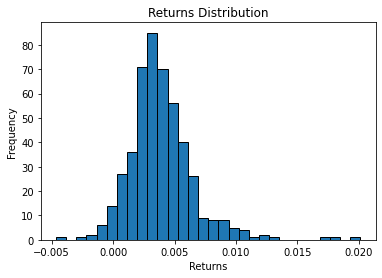

In [230]:
# Print Portfolio data
print(f"Portfolio: {PORTFOLIO} \nN. Stock: {nStocks}")
print(f"From: {time.iloc[0, 0]} To: {time.iloc[-1, 0]}")

plt.hist(ret_mean, bins=30, edgecolor='black')
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.title('Returns Distribution')
plt.show()

In [231]:
def generate_random_array(n):
    random_nums = np.random.rand(n)
    total = np.sum(random_nums)
    random_array = random_nums / total
    return random_array

e = np.ones((nStocks, 1))
weights = generate_random_array(nStocks)

print(f"B: {np.dot(e.T, weights)}")
np.all(weights > 0)

B: [1.]


True

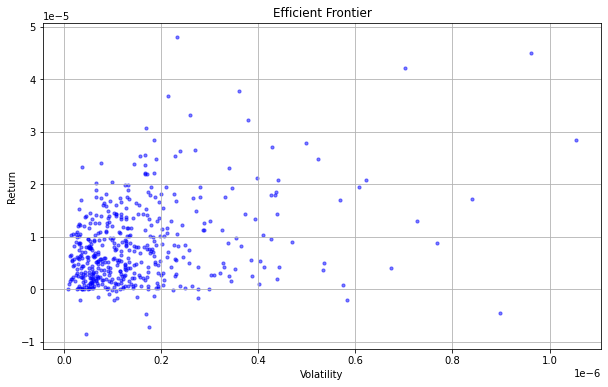

In [232]:
port_returns = []
port_volatility = []

for idx, w in enumerate(weights):
    port_returns.append(np.dot(w, ret_mean[idx]))

port_volatility = np.diag(np.dot(np.dot(cov, np.diag(weights)), cov.T))

plt.figure(figsize=(10, 6))
plt.scatter(port_volatility, port_returns, marker='o', color='b', s=10, alpha=0.5)
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.title('Efficient Frontier')
plt.grid(True)
plt.show()

# Portfolio Optimizations

We have $n$ avaiable assets. We call $w_i$ the quantity of money invested on the
$i$-th asset during the considered period and with $r_i$ the returns on the $i$-th
asset. We have two different constraints. The first one is non-negativity for the
variables (i.e., $w_i$ ≥ 0). It basically means that short selling (selling asset that
we still don’t own) is not allowed. We then have the budget constraint:

$
\begin{equation}
\sum_{i=1}^{n} w_i = B
\end{equation}
$



the total amount of money invested needs to be equal to the budget $B$ ($B$ can be simply set to 1).
Consider a stochastic model for the returns: $r ∈ R^n$ is a randomly generated vector with mean $\overline{r}$ and covariance $\Sigma$. Thus expected return will be:
$
\begin{equation}
\overline{r}^\intercal \, w
\end{equation}
$
and variance
$
\begin{equation}
x^\intercal \, \Sigma \, w
\end{equation}
$
Classic portfolio problem, described by Markowitz (1952), is a convex quadratic programming problem:
$
\begin{equation}
\begin{split}
\underset{w∈R^n}{min} \quad \gamma \, w^\intercal \, \Sigma \, w - \overline{r}^\intercal \, w \\
s.t. \quad e^\intercal w = 1 \\
w > 0
\end{split}
\end{equation} 
$
with $\gamma$ > 0 risk-aversion parameter. Goal is thus finding the set of assets that
minimizes the variance (risk connected to the given portfolio) while maximizing
the expected return (we obviously need to satisfy budget and non-negativity
constraints).

In [233]:
def loss(weights):
    return RISK_AVERSION * np.dot(weights.T, np.dot(cov, weights)) - np.dot(ret_mean.T, weights)

### Hessian and Lipschitz constant
Those functions are used to calculate the Hessian matrix and the Lipschitz constat for the whole problem, and for the single variable.

In [234]:
def lipschitz_constant(hessian):
    return scipy.linalg.eigh(hessian, subset_by_index=(len(hessian)-1, len(hessian)-1))[0][0]
    
def is_strongly_convex(hessian):
    return scipy.linalg.eigh(hessian, subset_by_index=(0,0))[0][0]

In [235]:
%%time
print("Hessian matrix")
hessian = nd.Hessian(loss)(weights)

print("Calculating sigma (strongly convex)")
sigma = is_strongly_convex(hessian)
is_sc = sigma > 0

if is_sc: print(f"Sigma: {sigma}, strongly convex")
else: print(f"Sigma: {sigma}, not strongly convex")

L = lipschitz_constant(hessian)
print(f"Lipschitz constant: {L}")

print("Lipschitz constant for single variable")
Li = np.repeat(L, len(hessian))

Hessian matrix
Calculating sigma (strongly convex)
Sigma: -1.922750125445152e-13, not strongly convex
Lipschitz constant: 0.01714451648920908
Lipschitz constant for single variable
CPU times: user 32min 59s, sys: 24.8 s, total: 33min 24s
Wall time: 4min 35s


## Projected Gradient Descent

$
\begin{equation}
\nabla f(w_k) = 2 \, \gamma \, \Sigma \, w - \overline{r}^\intercal\\
\end{equation} 
$

In [236]:
def gradient(w):
    return RISK_AVERSION * 2 * np.dot(w, cov) - ret_mean

## Frank-Wolfe Method

In [237]:
def get_min(gradient):
    A_eq = np.ones((1, nStocks))
    b_eq = 1

    # Constraint weights > 0
    A_ub = -np.eye(nStocks)
    A_ub = np.vstack((A_ub, np.ones(nStocks)))
    # Constraint weights > 0
    b_ub = np.zeros(nStocks)
    b_ub = np.append(b_ub, 1)

    res = linprog(grad, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(0, 1))
    return res.x


In [241]:
%%time
w = weights[0]

for itr in range(0, ITERATIONS):
    alpha = 2 / (2 + itr)

    grad = gradient(weights)
    w_t = get_min(grad)

    # Condition

    w = w + alpha * (w_t - w)

w
    

CPU times: user 502 ms, sys: 170 ms, total: 672 ms
Wall time: 121 ms


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.